# Project assignment  - 10k German News Articles

Author: Stefan Caminada <br>
Start: 2022-11-08

## Scope

### The task itself
The goal is to automatically classify newspaper articles with their topic. The data source can be found here: <a href="https://github.com/tblock/10kGNAD">10k German News Articles - Dataset</a>

### Assessed Factors
- clean and improve data
- apply exploratory data analysis on the text (understand main characteristics)
- train a base model
- evaluate base model
- improve base models performance
- train/evaluate/improve advanced models

## download data as proposed

In [1]:
!pip install fhnw-nlp-utils

In [2]:
%%capture

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.text import join_tokens

import pandas as pd
import numpy as np

In [3]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.google.com/uc?id=1EuluVm0PX-akbh_EN-jZM2QbxXZ1uDeq", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.google.com/uc?id=1XI2yUaDaAy0PlD-ETiK8VMV_W1vOQ97n", file)
data_test = load_dataframe(file)

In [4]:
print(data_train.shape)
print(data_test.shape)

(9245, 2)
(1028, 2)


In [5]:
data_train.head(3)

,text_original,label
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web


In [6]:
data_test.head(3)

,text_original,label
0,"Die Gewerkschaft GPA-djp lanciert den ""All-in-...",Wirtschaft
1,Franzosen verteidigen 2:1-Führung – Kritische ...,Sport
2,Neues Video von Designern macht im Netz die Ru...,Web


In [7]:
data = pd.concat([data_train, data_test])

In [8]:
data.head(3)

,text_original,label
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web


## cleaning / improving

In [9]:
!pip install missingno

import missingno as msno
%matplotlib inline

<AxesSubplot:>

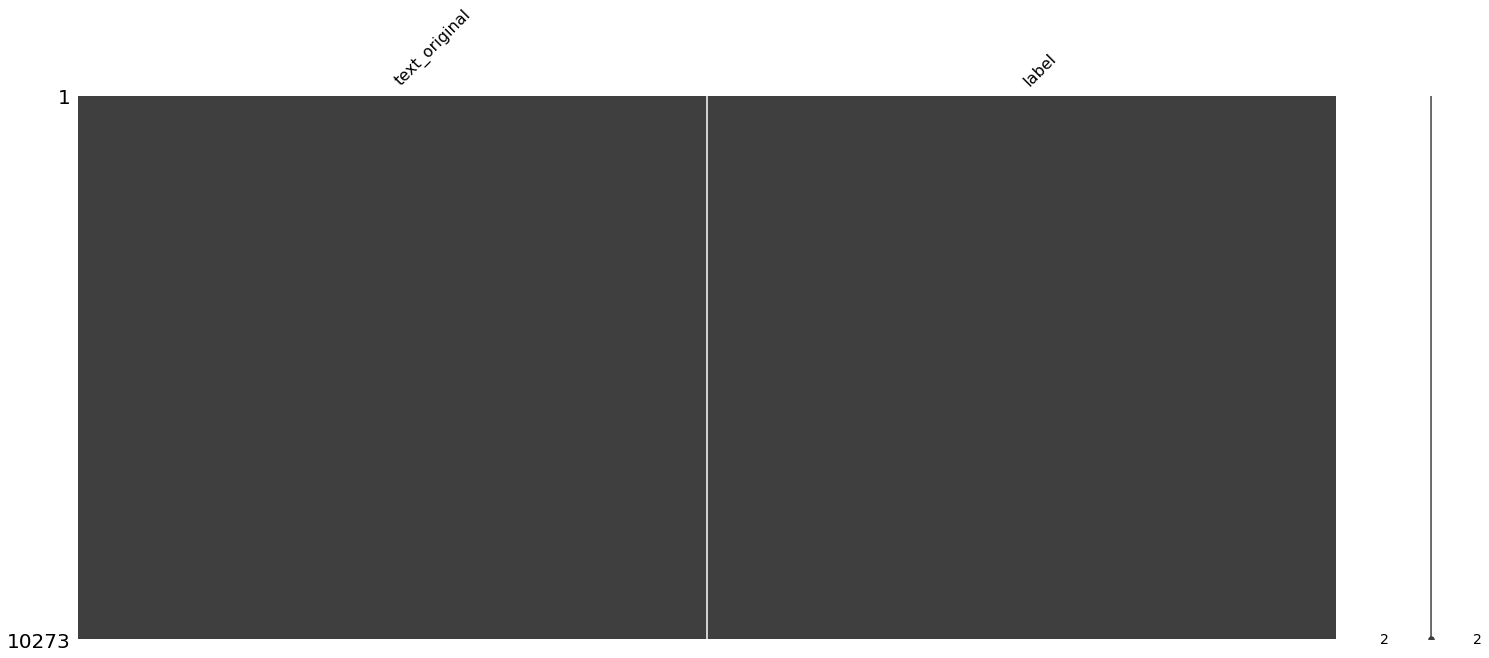

In [10]:
msno.matrix(data)

In [11]:
for col in data.columns:
    print(col, data[col].isnull().sum())

text_original 0
label 0


> Great! There is no missing data!

In [12]:
data[data["text_original"].str.contains("/>", na=False)]

,text_original,label


> No HTML Tags in the data!

In [13]:
def clean_text(text, keep_punctuation=False):
    """Cleans text by removing html tags, non ascii chars, digits and optionally punctuation

    Parameters
    ----------
    text : str
        The text to clean
    keep_punctuation : bool
        Defines if punctuation should be kept
        
    Returns
    -------
    str
        The cleaned text
    """
    import re
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    
    # remove any html tags (< /br> often found)
    text = re.sub(RE_TAGS, " ", text)
    
    if keep_punctuation:
        RE_ASCII_PUNCTUATION = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR_PUNCTUATION = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)
    
        # keep only ASCII + European Chars and whitespace, no digits, keep punctuation
        text = re.sub(RE_ASCII_PUNCTUATION, " ", text)
        # convert all whitespaces (tabs etc.) to single wspace, keep punctuation
        text = re.sub(RE_SINGLECHAR_PUNCTUATION, " ", text)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
        
        # keep only ASCII + European Chars and whitespace, no digits, no punctuation
        text = re.sub(RE_ASCII, " ", text)
        # convert all whitespaces (tabs etc.) to single wspace
        text = re.sub(RE_SINGLECHAR, " ", text)     
    
    text = re.sub(RE_WSPACE, " ", text)  
    return text

In [16]:
%%time
data = data.drop(["text"], axis=1, errors='ignore')
data = parallelize_dataframe(data, clean_text, field_read="text_original", field_write="text", keep_punctuation=True)

CPU times: total: 62.5 ms
Wall time: 1.57 s


In [17]:
data[~data["text"].str.contains("[A-Za-z]", na=False)]

,text_original,label,text


In [18]:
data["text"].head(5)

0     Jähriger fällt wohl bis Saisonende aus. Wien ...
1    Erfundene Bilder zu Filmen, die als verloren g...
2    Der frischgekürte CEO Sundar Pichai setzt auf ...
3    Putin Einigung, dass wir Menge auf Niveau von ...
4    Estland sieht den künftigen österreichischen P...
Name: text, dtype: object

In [19]:
!pip install fasttext

pretrained_model = "fasttext/supervised-models/lid.176.ftz"
download(url="https://dl.fbaipublicfiles.com/"+pretrained_model, path = pretrained_model)

def predict_lang(text):
    """Predicts the language of a sentence

    Parameters
    ----------
    text : str
        The text to predict the language
    model: fasttext model
        Fasttext model to predict the language
        
    Returns
    -------
    str
        The predicted language (e.g. en, de, ...)
    """
    
    lang = model.predict(text)[0]
    return str(lang)[11:13]

def predict_lang_df(df, field_read="text"):
    """Predicts the language of a column of text by calling predict_lang (primarily meant for parallel processing)

    Parameters
    ----------
    df : dataframe
        The dataframe
    field_read : str
        The column name to read from (default is text)
        
    Returns
    -------
    series
        The series with the predicted language
    """
    import fasttext
    from fhnw.nlp.utils.storage import download
    
    pretrained_model = "fasttext/supervised-models/lid.176.ftz"
    download(url="https://dl.fbaipublicfiles.com/"+pretrained_model, path = pretrained_model)

    model = fasttext.load_model(pretrained_model)
    
    series = df[field_read].map(
        lambda x: str(model.predict(x)[0])[11:13]
    )
    
    return series

In [20]:
%%time
data = parallelize_dataframe(data, predict_lang_df, processing_mode="df", n_jobs=6, field_read="text", field_write="lang")

# In case you get an error message "NameError: name 'model' is not defined" on your local machine
# you can also execute the above code as follows (without parallelization)
# data = pd.concat([data, data["text"].map(predict_lang).to_frame("lang")], axis=1)

CPU times: total: 78.1 ms
Wall time: 1.51 s


In [21]:
data.head(3)

,text_original,label,text,lang
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,Jähriger fällt wohl bis Saisonende aus. Wien ...,de
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",de
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,de


In [22]:
data["lang"].value_counts()

de    10273
Name: lang, dtype: int64

> Great! Really everything is written in German.

In [23]:
def tokenize(text, stopwords):
    """Tokenizes a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
        
    Returns
    -------
    list
        The tokenized text
    """
    from fhnw.nlp.utils.processing import is_iterable
    
    if isinstance(text, str):
        from nltk.tokenize import word_tokenize
        word_tokens = word_tokenize(text)
    elif is_iterable(text):
        word_tokens = text
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))

    return [word.lower() for word in word_tokens if word.lower() not in stopwords]

def tokenize_stem(text, stopwords, stemmer):
    """Tokenizes and stems a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    stemmer: stemmer
        The stemmer to use (e.g. SnowballStemmer)
        
    Returns
    -------
    list
        The tokenized and stemmed text
    """
    from fhnw.nlp.utils.processing import is_iterable
        
    if isinstance(text, str):
        from nltk.tokenize import word_tokenize
        word_tokens = word_tokenize(text)
    elif is_iterable(text):
        word_tokens = text
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))

    return [stemmer.stem(word.lower()) for word in word_tokens if word.lower() not in stopwords]

def tokenize_lemma(text, stopwords, lemmanizer, keep_ners=False):
    """Tokenizes and lemmatizes a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    lemmanizer: spacy nlp pipeline
        The lemmanizer to use (must be spacy nlp pipeline)
    keep_ner: bool
        Defines if named entities (NERs) should be keept in one token
        
    Returns
    -------
    list
        The tokenized and lemmatized text
    """
    from fhnw.nlp.utils.processing import is_iterable
        
    if isinstance(text, str):
        text = text
    elif is_iterable(text):
        from fhnw.nlp.utils.text import join_tokens
        text = join_tokens(text, set())
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))  
    
    if keep_ners:
        # HanoverTagger could be an alternative but takes longer 
        # see: https://textmining.wp.hs-hannover.de/Preprocessing.html#Lemmatisierung-und-Wortarterkennung
        doc = lemmanizer(text, disable=['tagger', 'parser'])

        tokens = list()
        ner_idx = 0
        tok_idx = 0

        # keep ner in one token
        while tok_idx < len(doc):
            if ner_idx >= len(doc.ents) or doc[tok_idx].idx < doc.ents[ner_idx].start_char:
                if doc[tok_idx].is_alpha and not doc[tok_idx].is_punct and doc[tok_idx].text.lower() not in stopwords and doc[tok_idx].lemma_.lower() not in stopwords:
                    #print("token ", doc[tok_idx].lemma_.lower())
                    tokens.append(doc[tok_idx].lemma_.lower())

                tok_idx += 1
            else:
                #print("ner ", doc.ents[ner_idx].lemma_.lower())
                tokens.append(doc.ents[ner_idx].lemma_.lower())

                tok_idx += 1
                while tok_idx < len(doc) and doc[tok_idx].idx < doc.ents[ner_idx].end_char:
                    tok_idx += 1

                ner_idx += 1

        return tokens
    else:
        doc = lemmanizer(text, disable=['tagger', 'parser', 'ner']) 
        return [tok.lemma_.lower() for tok in doc if tok.is_alpha and not tok.is_punct and tok.text.lower() not in stopwords and tok.lemma_.lower() not in stopwords]


def normalize(text, stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False):
    """Normalizes (e.g. tokenize and stem) a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    stemmer: stemmer
        The stemmer to use (e.g. SnowballStemmer) or None to disable stemming
    lemmanizer: spacy nlp pipeline
        The lemmanizer to use (must be spacy nlp pipeline) or None to disable lemmantization
    lemma_with_ner: bool
        Defines if named entities (NERs) should be keept in one token
        
    Returns
    -------
    list
        The normalized text
    """
        
    if lemmanizer is not None:
        return tokenize_lemma(text, stopwords, lemmanizer, keep_ners=lemma_with_ner)
    elif stemmer is not None:
        return tokenize_stem(text, stopwords, stemmer)
    else:
        return tokenize(text, stopwords)




In [24]:
!pip install spacy>=3.0.5
!pip install nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import spacy
!python -m spacy download de_core_news_md

nlp = spacy.load("de_core_news_md")

import nltk
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stopwords = set(stopwords.words("german"))
#stopwords = set(nlp.Defaults.stop_words)
empty_stopwords = set()

[+] Download and installation successful
You can now load the package via spacy.load('de_core_news_md')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\s_cam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s_cam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Setup Stopwords

In [25]:
print(stopwords)

{'noch', 'für', 'die', 'bei', 'eures', 'welcher', 'euch', 'meinem', 'meines', 'ihren', 'von', 'es', 'weg', 'manchem', 'mich', 'jedes', 'wollen', 'jenen', 'durch', 'warst', 'deinen', 'diesem', 'deiner', 'ihn', 'ihre', 'jenem', 'allen', 'jene', 'keinem', 'selbst', 'sehr', 'seiner', 'eurem', 'jedem', 'mit', 'dem', 'dass', 'als', 'bin', 'werde', 'auch', 'können', 'könnte', 'welche', 'sind', 'eines', 'ihres', 'was', 'zwar', 'welchen', 'welchem', 'ihrem', 'er', 'vor', 'nicht', 'seinem', 'dieselbe', 'im', 'über', 'haben', 'desselben', 'anderem', 'einiges', 'solcher', 'dann', 'dir', 'du', 'dazu', 'jenes', 'in', 'oder', 'jeden', 'vom', 'sie', 'am', 'nun', 'wo', 'wird', 'kein', 'anderen', 'anders', 'sondern', 'anderer', 'keiner', 'einiger', 'man', 'andern', 'machen', 'zur', 'alle', 'also', 'doch', 'um', 'weiter', 'manchen', 'jener', 'ihnen', 'diesen', 'indem', 'wie', 'zum', 'an', 'keines', 'unseres', 'mir', 'ins', 'denselben', 'so', 'dessen', 'ist', 'bist', 'auf', 'sonst', 'der', 'derer', 'dort'

In [26]:
%%time
data['token_clean'] = data['text'].apply(normalize, args=(empty_stopwords, None, None, False))

CPU times: total: 7.48 s
Wall time: 16.9 s


In [27]:
data.head(3)

,text_original,label,text,lang,token_clean
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,Jähriger fällt wohl bis Saisonende aus. Wien ...,de,"[jähriger, fällt, wohl, bis, saisonende, aus, ..."
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",de,"[erfundene, bilder, zu, filmen, ,, die, als, v..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,de,"[der, frischgekürte, ceo, sundar, pichai, setz..."


In [28]:
%%time
data['text_clean'] = data['token_clean'].apply(join_tokens, args=(empty_stopwords))

CPU times: total: 15.6 ms
Wall time: 75.4 ms


In [29]:
data.head(3)

,text_original,label,text,lang,token_clean,text_clean
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,Jähriger fällt wohl bis Saisonende aus. Wien ...,de,"[jähriger, fällt, wohl, bis, saisonende, aus, ...",jähriger fällt wohl bis saisonende aus . wien ...
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",de,"[erfundene, bilder, zu, filmen, ,, die, als, v...","erfundene bilder zu filmen , die als verloren ..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,de,"[der, frischgekürte, ceo, sundar, pichai, setz...",der frischgekürte ceo sundar pichai setzt auf ...


In [30]:
%%time
data['token_lemma'] = data['token_clean'].apply(normalize, args=(stopwords,None,nlp,False))

CPU times: total: 48.4 s
Wall time: 2min 6s


In [31]:
data.head(3)

,text_original,label,text,lang,token_clean,text_clean,token_lemma
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,Jähriger fällt wohl bis Saisonende aus. Wien ...,de,"[jähriger, fällt, wohl, bis, saisonende, aus, ...",jähriger fällt wohl bis saisonende aus . wien ...,"[jähriger, fallen, wohl, saisonende, wien, rap..."
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",de,"[erfundene, bilder, zu, filmen, ,, die, als, v...","erfundene bilder zu filmen , die als verloren ...","[erfunden, bild, film, verlieren, gelten, the,..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,de,"[der, frischgekürte, ceo, sundar, pichai, setz...",der frischgekürte ceo sundar pichai setzt auf ...,"[frischgekürte, ceo, sundar, pichai, setzen, u..."


In [32]:
def create_ngram_counts(df, n = 2, field_read="token_lemma"):
    """Creates the n-gram counts of a column of text tokens

    Parameters
    ----------
    df : dataframe
        The dataframe
    n : int
        The n grams to create (e.g. 2 for bi-gram)
    field_read : str
        The column name to read from (default is token_lemma)
        
    Returns
    -------
    Counter
        The n-gram counts
    """
    from collections import Counter
        
    counter = Counter()

    # see https://stackoverflow.com/a/17071908
    #_ = df[field_read].apply(lambda x: counter.update(nltk.ngrams(x, n)))
    #_ = df[field_read].apply(lambda x: counter.update([" ".join(grams) for grams in nltk.ngrams(x, n)]))
    _ = df[field_read].apply(lambda x: counter.update([" ".join(x[i:i+n]) for i in range(len(x)-n+1)]))
    
    return counter

def plot_ngram_counts(counter, n_most_common, title="Term frequencies"):
    """Plots the n-gram counts

    Parameters
    ----------
    counter : Counter
        The counter of the n-grams
    n_most_common : int
        The n most common n-grams to plog
    title : str
        The title of the plot
    """
    
    import matplotlib.pyplot as plt
        
    y = [count for tag, count in counter.most_common(n_most_common)]
    x = [tag for tag, count in counter.most_common(n_most_common)]

    plt.bar(x, y)
    plt.title(title)
    plt.ylabel("Frequency")
    #plt.yscale('log') # set log scale for y-axis
    plt.xticks(rotation=90)
    for i, (tag, count) in enumerate(counter.most_common(n_most_common)):
        plt.text(i, count, f' {count} ', rotation=90, ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
    plt.xlim(-0.6, len(x)-0.4) # set tighter x lims
    plt.tight_layout() # change the whitespace such that all labels fit nicely
    plt.show()

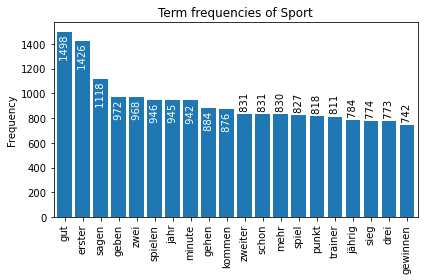

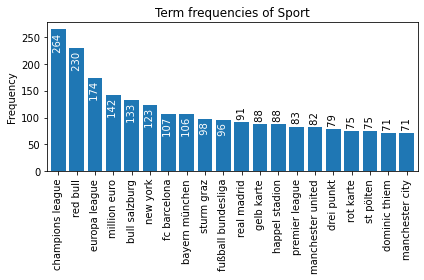

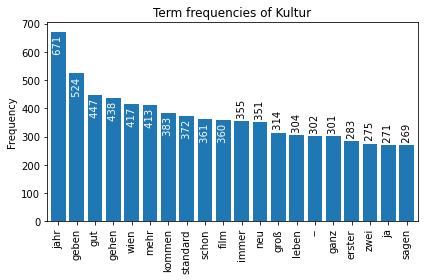

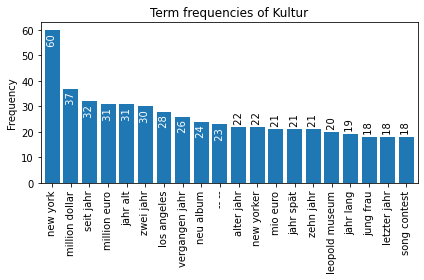

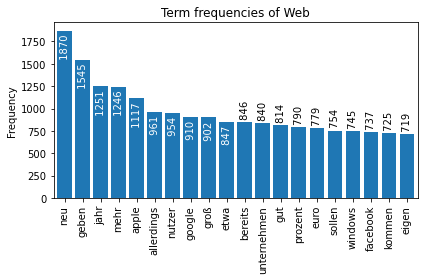

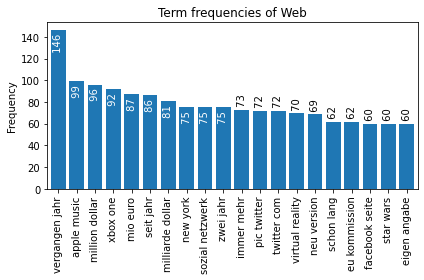

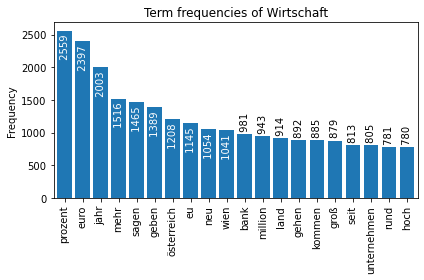

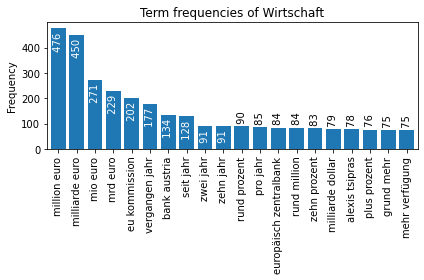

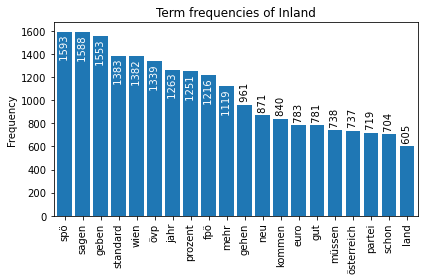

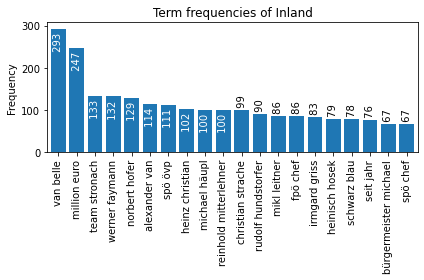

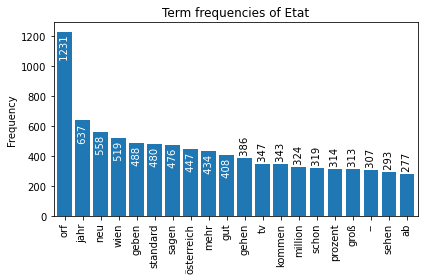

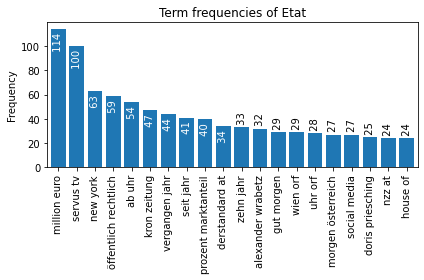

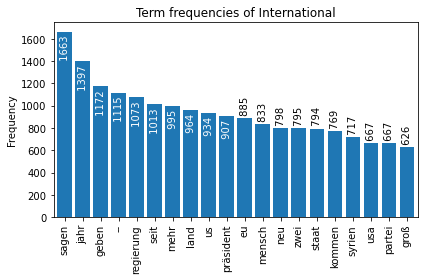

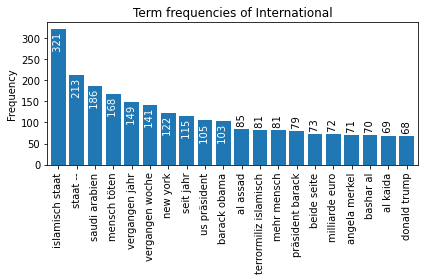

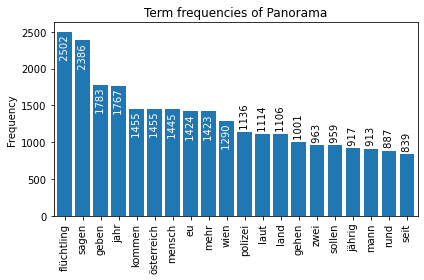

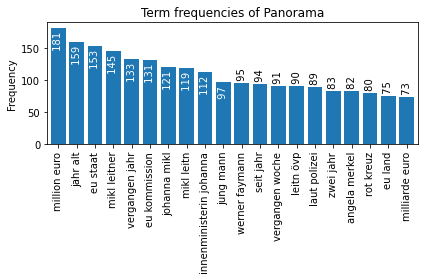

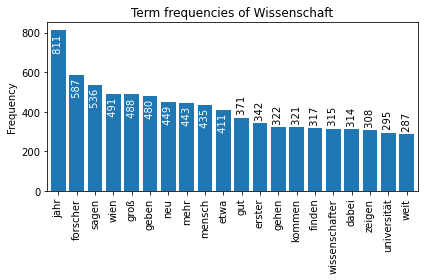

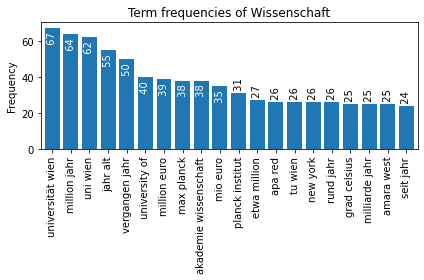

In [33]:
for label in data["label"].unique():
    ngrams_1 = create_ngram_counts(data.loc[(data["label"] == label)], 1)
    ngrams_2 = create_ngram_counts(data.loc[(data["label"] == label)], 2)
    
    plot_ngram_counts(ngrams_1, 20, "Term frequencies of "+label)
    plot_ngram_counts(ngrams_2, 20, "Term frequencies of "+label)

In [34]:
!pip install wordcloud

def create_word_cloud(df, label, field="token_lemma"):
    """Creates a wordcloud of a column of text

    Parameters
    ----------
    df : dataframe
        The dataframe
    label: str
        The label for which the wordcloud is generated (only for printing - df needs to be filtered in the calling code)
    field : str
        The column name to read from (default is token_lemma)
    """
        
    import matplotlib.pyplot as plt
    from collections import Counter
    from wordcloud import WordCloud
    
    counter = Counter()
    # see https://stackoverflow.com/a/17071908
    _ = df["token_lemma"].apply(counter.update)
    
    print(label, "- with", len(counter.keys()), "number of words.")

    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(counter)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Sport - with 30162 number of words.


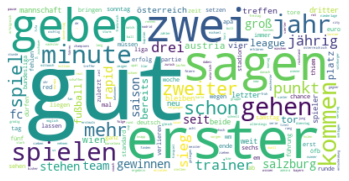

Kultur - with 33756 number of words.


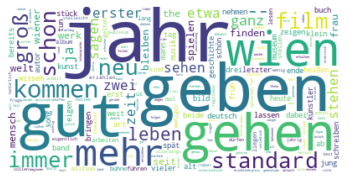

Web - with 37819 number of words.


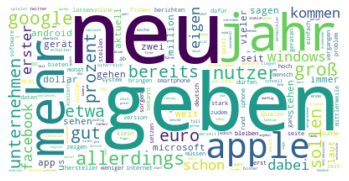

Wirtschaft - with 38595 number of words.


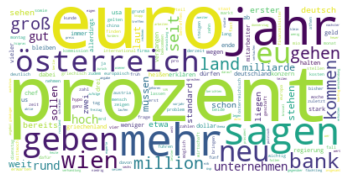

Inland - with 32693 number of words.


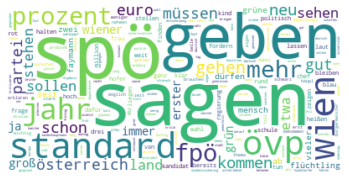

Etat - with 26562 number of words.


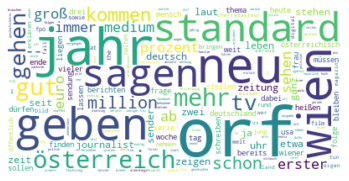

International - with 34213 number of words.


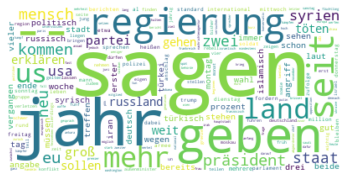

Panorama - with 44771 number of words.


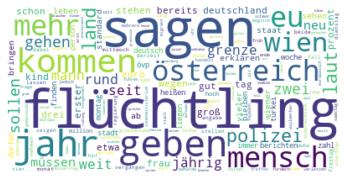

Wissenschaft - with 27861 number of words.


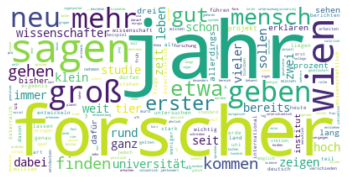

In [35]:
for label in data["label"].unique():
    create_word_cloud(data.loc[(data["label"] == label)], label, field="token_lemma")

## exploratory data analysis

Panorama         1678
Web              1677
International    1511
Wirtschaft       1411
Sport            1201
Inland           1015
Etat              668
Wissenschaft      573
Kultur            539
Name: label, dtype: int64

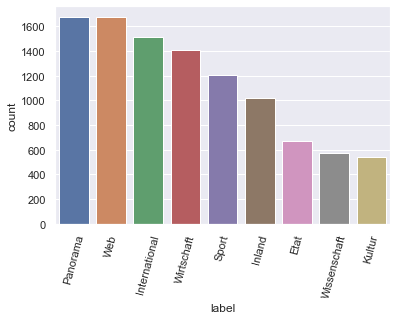

In [36]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=data, order=data['label'].value_counts().index)
ax.tick_params(axis='x', rotation=75)
data['label'].value_counts()

## base model

In [37]:
from sklearn.model_selection import train_test_split

# ensure we retain the class weights by using stratify
data_train, data_test = train_test_split(data, shuffle=True, random_state=43, stratify=data["label"])

In [38]:
X_train, y_train = data_train["token_lemma"], data_train["label"]
X_test, y_test = data_test["token_lemma"], data_test["label"]

In [39]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline([
         ("vec", CountVectorizer(tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])
pipe.fit(X_train, y_train)

CPU times: total: 1.86 s
Wall time: 1.08 s


Pipeline(steps=[('vec',
                 CountVectorizer(preprocessor=<function <lambda> at 0x00000219BBD8C1F0>,
                                 tokenizer=<function <lambda> at 0x00000219BBD8C310>)),
                ('tfidf', TfidfTransformer()), ('clf', SGDClassifier())])

In [40]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

## base model evaluation

In [41]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
               precision    recall  f1-score   support

         Etat       1.00      0.99      0.99       501
       Inland       0.99      0.99      0.99       761
International       1.00      0.99      0.99      1133
       Kultur       1.00      1.00      1.00       404
     Panorama       0.99      0.99      0.99      1258
        Sport       1.00      1.00      1.00       901
          Web       0.99      0.99      0.99      1258
   Wirtschaft       0.98      0.99      0.99      1058
 Wissenschaft       1.00      1.00      1.00       430

     accuracy                           0.99      7704
    macro avg       0.99      0.99      0.99      7704
 weighted avg       0.99      0.99      0.99      7704

Test:
               precision    recall  f1-score   support

         Etat       0.93      0.80      0.86       167
       Inland       0.81      0.81      0.81       254
International       0.85      0.88      0.87       378
       Kultur       0.85      0.87      0.86    

Set Population: 7704
Accuracy: 0.9936


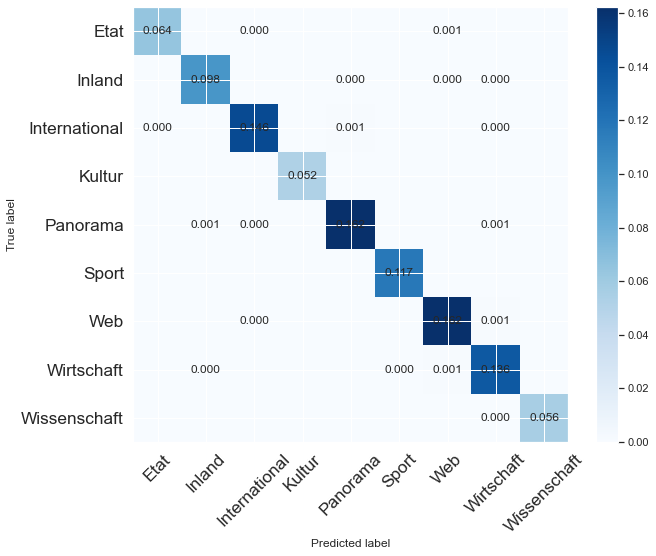

Set Population: 2569
Accuracy: 0.8649


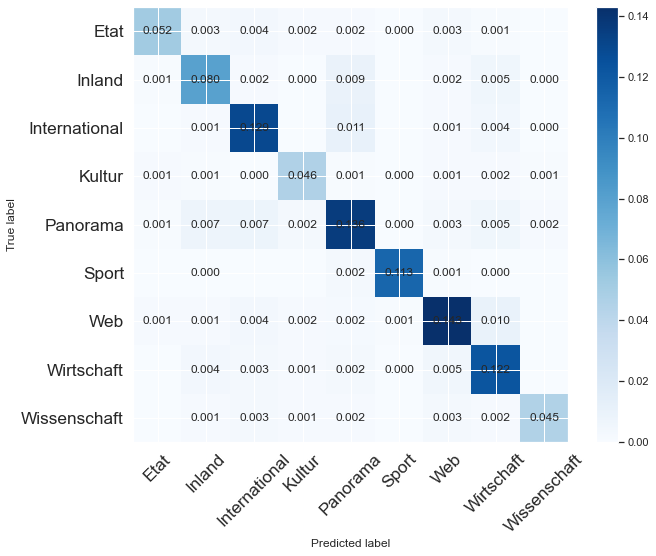

In [42]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

## base model improvement

In [43]:
from sklearn.metrics import f1_score, make_scorer

scoring_function = make_scorer(f1_score, average='weighted')

In [44]:
!pip install scikit-optimize

In [45]:
# https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html#sphx-glr-auto-examples-sklearn-gridsearchcv-replacement-py
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

pipe = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])

params = {
    "vec__max_df": Real(0.5, 1.0), 
    "vec__min_df": Real(0.0001, 0.3, prior="log-uniform"), 
    #"vec__ngram_range": Categorical([(1, 1), (1, 2), (2, 2)]), 
    "tfidf__use_idf": Categorical([True, False]),
    "tfidf__norm": ["l1", "l2"],
    "tfidf__sublinear_tf": Categorical([True, False]),
    #"clf__class_weight": Categorical([None, "balanced"]),
    "clf__alpha": Real(0.0000001, 0.1, prior="log-uniform"),
}

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(params, 50)],
    scoring=scoring_function,
    n_jobs=-1, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=2
)

In [ ]:
%%time

_ = opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
print(opt.best_score_)
print(opt.best_params_)

In [ ]:
import matplotlib.pyplot as plt
from skopt.plots import plot_objective

_ = plot_objective(opt.optimizer_results_[0])
plt.show()

In [ ]:
pipe.set_params(**opt.best_params_)
pipe.fit(X_train, y_train)

In [ ]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

In [ ]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
pipe.predict(['Der, FCZ, hat, gegen, die, Berner, Young, Boys, 3:0, verloren, Das, Ergebnis, lässt, zu, wünschen, übrig.'])

In [ ]:
pipe.predict(['welser, stempelhersteller, verbreiteren'])

In [ ]:
X_train

## advanced model

## advanced model evalutation

## advanced model improvement

## credits:
- Main NLP Inputs: <a href="https://github.com/markif/2021_HS_DAS_NLP_Notebooks">markif/2021_HS_DAS_NLP_Notebooks</a>
- Visualization of missing values: <a href="https://github.com/ResidentMario/missingno">ResidentMario/missingno</a>